# Classification Model to predict credit score 

***About the dataset:*** 

The dataset is available on Kaggle website at https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data. 

The data is presented as a challenge to predict credit score given a customer's bank details. 

The dataset itself is some example data given to help predict new information. There are over 27 columns and 100000 rows in this dataset, with around 8 rows each for 12500 unique customers.

***Objective:*** Classify a customer's credit score as "good" or "poor", given customer financial data.

***Approach:*** 

- We are going to take the following steps to build a classification model: 
    1. Handle missing, NAN, inf data
    2. Consolidate similar rows together and standardize/cleanup data
    3. Select important features to build our models based on data exploration
    4. Create or delete features/columns based on results of data explorations
    5. Build base classifiers models on the data
    6. Ensemble the results together to get a more accurate accuracy score

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

### Reading Data

In [2]:
data = pd.read_csv("train.csv")
data.head()
print(len(data))
data.head()

C:\Users\Yash\AppData\Local\Temp\ipykernel_32612\2988695618.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("train.csv")


100000


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


***Attributes:***
- ID - Represents a unique identification of an entry(Continous)
- CustomerID - Represents a unique identification of a person(Continuos)
- Month - Represents the month of the year(Nominal)
- Name - Represents the name of a person(Nominal)
- Age - Represents the age of the person
- SSN - Represents the social security number of a person
- Occupation - Represents the occupation of the person
- Annual_Income - Represents the annual income of the person
- Monthly_Inhand_Salary - Represents the monthly base salary of a person
- Num_Bank_Accounts - Represents the number of bank accounts a person holds
- Num_Credit_Card - Represents the number of other credit cards held by a person
- Interest_Rate - Represents the interest rate on credit card
- Num_of_Loan - Represents the number of loans taken from the bank
- Type_of_Loan - Represents the types of loan taken by a person
- Delay_from_due_date - Represents the average number of days delayed from the payment date
- Num_of_Delayed_Payment - Represents the average number of payments delayed by a person
- Changed_Credit_Limit - Represents the percentage change in credit card limit
- Num_Credit_Inquiries - Represents the number of credit card inquiries
- Credit_Mix - Represents the classification of the mix of credits
- Outstanding_Debt - Represents the remaining debt to be paid (in USD)
- Credit_Utilization_Ratio - Represents the utilization ratio of credit card
- Credit_History_Age - Represents the age of credit history of the person
- Payment_of_Min_Amount - Represents whether only the minimum amount was paid by the person
- Total_EMI_per_month - Represents the monthly EMI payments (in USD)
- Amount_invested_monthly - Represents the monthly amount invested by the customer (in USD)
- Payment_Behaviour - Represents the payment behavior of the customer (in USD)
- Monthly_Balance - Represents the monthly balance amount of the customer (in USD)

***Label:***
- Credit Score - A rating of "Good", "Standard", or "Poor"

For our predicted classification, we group the "Good" and "Standard" together as "Good", and framed this problem as a binary classification problem.

### Data Preprocessing: Cleaning and Feature Engineering

We want to delete the name and SSN from this data to reduce dimensionality. Name and SSN don't have significance
in this data to predict credit score. We will use Customer_ID to uniquely identify each person.

Each customer ID has several rows dedicated for them for each month's info. We will combine these records in one row.

We decided to take the mode of the columns for the set of rows associated per customer ID. Before taking the average, we need to clean the rows that have negatives and '-' (bad data).

In [3]:
df = data.drop(['Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour', 'Monthly_Inhand_Salary', 'Payment_of_Min_Amount', 'Credit_Mix'], axis=1)

As you notice above, we are also dropping several other columns which we decided were not useful as we continued our data exploration and cleaning.

In [4]:
mode_ages = df.groupby('Customer_ID')['Age'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['Age'] = df.apply(lambda row: mode_ages[row['Customer_ID']] if pd.notnull(row['Age']) else None, axis=1)

In [5]:
df['Age'].value_counts()

28      3136
31      3104
26      3048
25      3016
38      2992
36      2952
39      2952
44      2936
34      2920
37      2920
27      2920
35      2904
22      2896
32      2856
41      2840
19      2824
20      2816
30      2816
23      2792
29      2768
43      2744
21      2744
40      2736
24      2664
42      2664
45      2640
33      2640
18      2568
46      1704
15      1600
17      1568
16      1480
48      1464
53      1424
55      1416
52      1376
49      1352
51      1344
50      1328
54      1320
14      1256
47      1208
56       328
41_        8
-500       8
44_        8
Name: Age, dtype: int64

As you see, there are still some ages with underscores and negative values. We need to fix these rows. This is done below.

In [6]:
df['Age'] = pd.to_numeric(df['Age'].astype(str).str.replace('_', ''), errors='coerce')
df = df.dropna(subset=['Age'])
df = df[df['Age'] >= 0]
df.reset_index(drop=True, inplace=True)

In [7]:
df['Age'].value_counts()

28    3136
31    3104
26    3048
25    3016
38    2992
36    2952
39    2952
44    2944
34    2920
27    2920
37    2920
35    2904
22    2896
32    2856
41    2848
19    2824
20    2816
30    2816
23    2792
29    2768
43    2744
21    2744
40    2736
24    2664
42    2664
45    2640
33    2640
18    2568
46    1704
15    1600
17    1568
16    1480
48    1464
53    1424
55    1416
52    1376
49    1352
51    1344
50    1328
54    1320
14    1256
47    1208
56     328
Name: Age, dtype: int64

We now fix the occupations column, since it is categorical data. Since there are a large number of occupations, we decided to categorize them into 3 categories and one hot encode for each row. This provides a balance between dimensionality and the predictive power of the feature.

In [8]:
df['Occupation'].value_counts()

_______          7061
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5904
Writer           5885
Name: Occupation, dtype: int64

In [9]:
occupation_categories = {
    'Lawyer': 'Arts',
    'Architect': 'STEM',
    'Engineer': 'STEM',
    'Scientist': 'STEM',
    'Mechanic': 'Business',
    'Accountant': 'Business',
    'Developer': 'STEM',
    'Media_Manager': 'Arts',
    'Teacher': 'Arts',
    'Entrepreneur': 'Business',
    'Doctor': 'STEM',
    'Journalist': 'Arts',
    'Manager': 'Business',
    'Musician': 'Arts',
    'Writer': 'Arts'
}

df['Occupation_Category'] = df['Occupation'].map(occupation_categories)
df_encoded = pd.get_dummies(df, columns=['Occupation_Category'], prefix='Occupation_Category')
df_encoded.drop(['Occupation'], axis=1, inplace=True)

df['Occupation_Category'].value_counts()

Arts        36896
STEM        31326
Business    24709
Name: Occupation_Category, dtype: int64

We now look at Annual Income-- we see that once again, there are several rows where there are ill-formatted values with underscores. We clean this below.

In [10]:
df_encoded['Annual_Income'].value_counts()

36585.12      16
20867.67      16
17273.83      16
33029.66      15
17816.75      15
              ..
73773.48_      1
33199.13_      1
10494.44_      1
172441.08_     1
29101.2_       1
Name: Annual_Income, Length: 18938, dtype: int64

In [11]:
mode_income = df_encoded.groupby('Customer_ID')['Annual_Income'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_encoded['Annual_Income'] = df_encoded.apply(lambda row: mode_income[row['Customer_ID']] if pd.notnull(row['Annual_Income']) else None, axis=1)

df_encoded['Annual_Income'] = pd.to_numeric(df_encoded['Annual_Income'].astype(str).str.replace('_', ''), errors='coerce')
df_encoded = df_encoded.dropna(subset=['Annual_Income'])
df_encoded = df_encoded[df_encoded['Annual_Income'] >= 0]
df_encoded.reset_index(drop=True, inplace=True)

In [12]:
df_encoded['Annual_Income'].value_counts()
# fixed below

109945.320    16
9141.630      16
22434.160     16
20867.670     16
36585.120     16
              ..
14784.450      8
60573.960      8
18413.795      8
30622.730      8
39628.990      8
Name: Annual_Income, Length: 12487, dtype: int64

Recall that the dataset has a row for each of the 8 months of the 12500 customers. We're going to consolidate all the months of a customer into 1 row in the future, so we need to find a way to combine rows.

We noticed a pattern here that for all columns-- we want the mode of all rows per customer_id. We didn't use mean here because there are too many missing values, and the variation by month is 0 or close to 0 anyway.

We also handle bad formats with underscores here as well.

In [13]:
columns_to_process = [
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance',
    'Occupation_Category_Arts',
    'Occupation_Category_Business',
    'Occupation_Category_STEM'
]

for column in columns_to_process:
    mode_values = df_encoded.groupby('Customer_ID')[column].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    df_encoded[column] = df_encoded.apply(lambda row: mode_values[row['Customer_ID']] if pd.notnull(row[column]) else None, axis=1)
    df_encoded[column] = pd.to_numeric(df_encoded[column].astype(str).str.replace('_', ''), errors='coerce')

df_encoded = df_encoded[~df_encoded.isin([np.inf, -np.inf, np.nan]).any(axis=1)]
df_encoded.reset_index(drop=True, inplace=True)

Below, we do some feature engineering/cleaning here to truncate the months in the Credit_History_Age column to map to the Credit_History_Years column. This converts the previously nonnumeric data into numeric data. 

In [14]:
def extract_years(age_str):
    if pd.notnull(age_str) and 'Year' in age_str:
        return int(age_str.split(' ')[0])
    else:
        return 0

df_encoded['Credit_History_Years'] = df_encoded['Credit_History_Age'].apply(extract_years)
df_encoded.drop(['Credit_History_Age'], axis=1, inplace=True)

In [15]:
mode_values = df_encoded.groupby('Customer_ID')['Credit_History_Years'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_encoded['Credit_History_Years'] = df_encoded.apply(lambda row: mode_values[row['Customer_ID']] if pd.notnull(row['Credit_History_Years']) else None, axis=1)
df_encoded['Credit_History_Years'] = pd.to_numeric(df_encoded['Credit_History_Years'].astype(str).str.replace('_', ''), errors='coerce')
df_encoded.reset_index(drop=True, inplace=True)

In [16]:
df_consolidated = df_encoded.groupby('Customer_ID').first().reset_index()

We are consolidating the different months of a specific customer into one row for the unique customer and consolidating the other information as shown in the steps from above. All the values for a specific customers are the same over the different months, and we consolidate all their rows into one specific row. We do this to make sure we can reduce the overall volume of data that we are dealing with allowing for all the models to run more efficiently.

We also drop the Month and ID features, because they were only used as identifiers for the same person over time.

In [17]:
df_final = df_consolidated.drop(['Month', 'ID'], axis=1)
df_final.columns

Index(['Customer_ID', 'Age', 'Annual_Income', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
       'Credit_Score', 'Occupation_Category_Arts',
       'Occupation_Category_Business', 'Occupation_Category_STEM',
       'Credit_History_Years'],
      dtype='object')

In [18]:
columns_to_check = [
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

df_final = df_final[(df_final[columns_to_check] > 0).all(axis=1)]
df_final.reset_index(drop=True, inplace=True)

We have now finished a significant amount of data cleaning. We have deleted unnessary columns, imputed missing values, and consolidated our dataset. We also got rid of rows that have bad characters and negative values for columns that don't make sense to have negative values.

We now create a new feature for average debt per account which combines Outstanding_Debt and Num_Bank_Accounts. We tehn drop these two columns to reduce dimensionality, hoping that the information is encoded in the engineered feature. 

In [19]:
df_final['Average_Debt_Per_Bank_Account'] = df_final['Outstanding_Debt'] / df_final['Num_Bank_Accounts']
df_final.drop(['Outstanding_Debt', 'Num_Bank_Accounts'], axis=1, inplace=True)

Lastly, we decided to group the Standard and Good class label together and keep Poor as the other class label because we thought it would be a good indicator of if someone is approved of a loan (Yes/No).

In [20]:
df_final['Credit_Score'] = df_final['Credit_Score'].replace({'Good': 1, 'Standard': 1, 'Poor': -1})

# Data Exploration

In [21]:
df_final[['Age', 'Annual_Income', 'Average_Debt_Per_Bank_Account', 'Num_Credit_Card', 'Interest_Rate', 
                       'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
                       'Num_Credit_Inquiries', 'Credit_Utilization_Ratio',
                       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score', 'Credit_History_Years']].describe()

,Age,Annual_Income,Average_Debt_Per_Bank_Account,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_History_Years
count,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000,9559.000000
mean,32.343969,47240.281926,288.177385,5.800607,16.200753,4.182132,23.511246,14.510095,11.285067,6.613976,25.266172,118.950923,611.565645,253.771821,0.324616,16.381107
std,10.489350,35835.093270,211.479255,2.075675,8.819134,2.253636,15.192166,5.737207,6.745292,3.615687,2.099805,120.349946,2080.376228,174.437598,0.945896,8.273524
min,14.000000,7005.930000,0.042500,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,20.100770,4.462837,10.010194,0.007760,-1.000000,0.000000
25%,24.000000,18620.400000,142.642500,4.000000,9.000000,2.000000,12.000000,10.000000,6.340000,4.000000,23.750327,42.111903,106.156616,176.570395,-1.000000,10.000000
50%,32.000000,35413.430000,248.365714,6.000000,16.000000,4.000000,21.000000,15.000000,10.120000,6.000000,24.944097,78.229629,118.837364,224.132692,1.000000,16.000000
75%,40.000000,66592.740000,389.046667,7.000000,22.000000,6.000000,30.000000,19.000000,16.150000,9.000000,26.441445,163.678827,145.114437,263.697270,1.000000,22.000000
max,56.000000,179987.280000,1485.870000,11.000000,34.000000,9.000000,62.000000,28.000000,29.980000,17.000000,38.112157,1779.103254,10000.000000,1271.056599,1.000000,33.000000


Below, we see the imbalance of class between Good and Poor classifications. We will use techniques like SMOTE to oversample underrepresented classes.

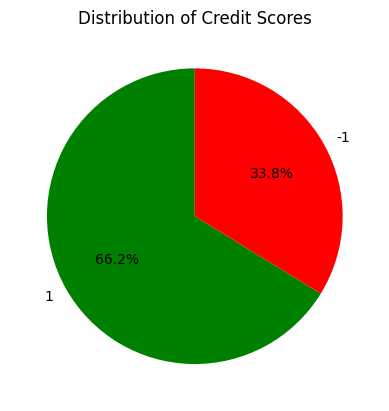

In [22]:
counts = df_final['Credit_Score'].value_counts()

# Plot a pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Credit Scores')
plt.show()

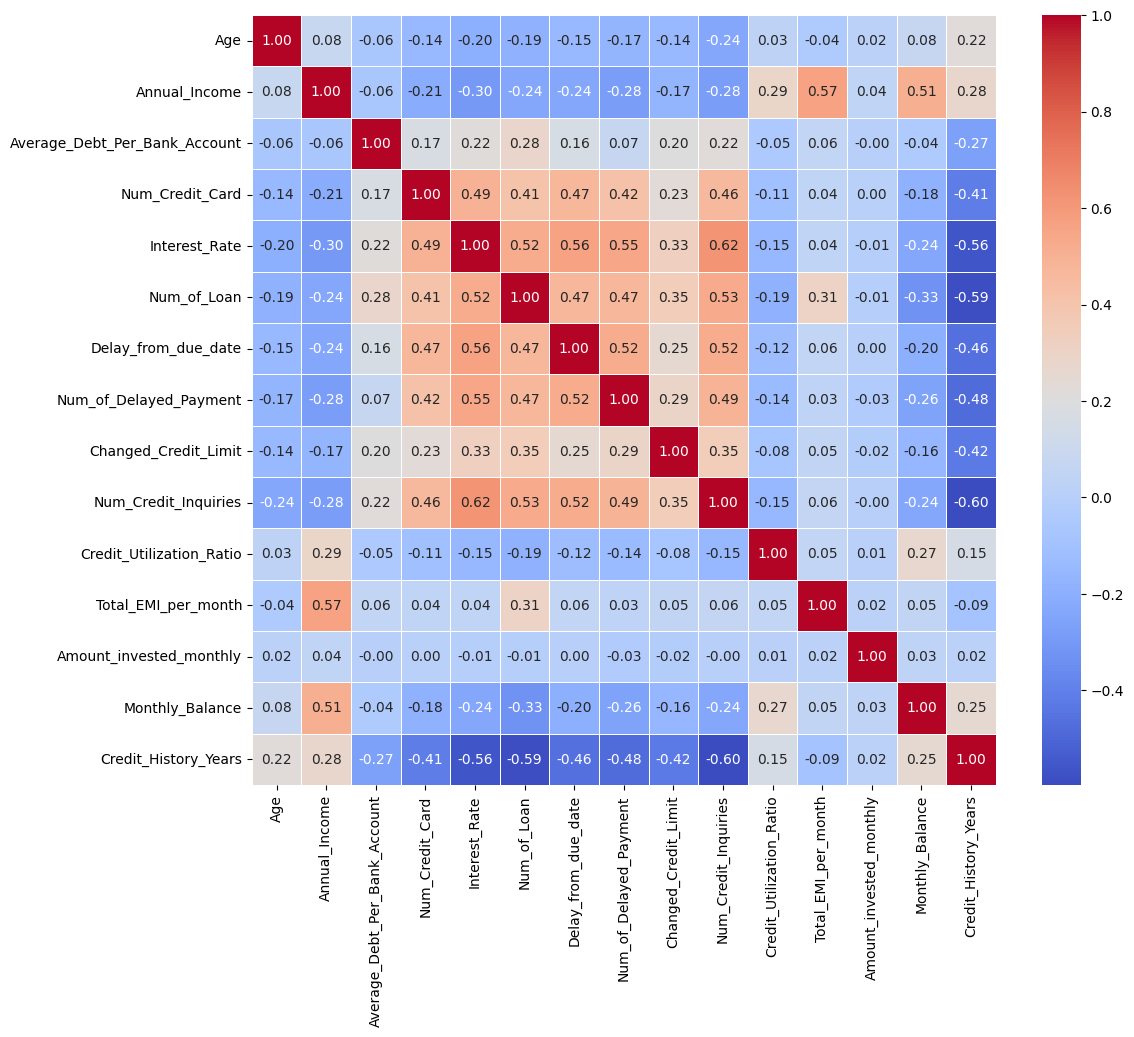

In [23]:
correlation_matrix = df_final[['Age', 'Annual_Income', 'Average_Debt_Per_Bank_Account', 'Num_Credit_Card', 'Interest_Rate',
                                       'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                                       'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly',
                                       'Monthly_Balance', 'Credit_History_Years']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

We see that the highest correlation in the matrix is between interest rate and number of credit inquiries. 
Is this a high enough correlation to drop one of the columns? 

If we perform PCA in hopes to reduce dimensionality while keeping variation, we'd lose understanding of our features. We decide that this is not currently necessary, and will reevaluate later.

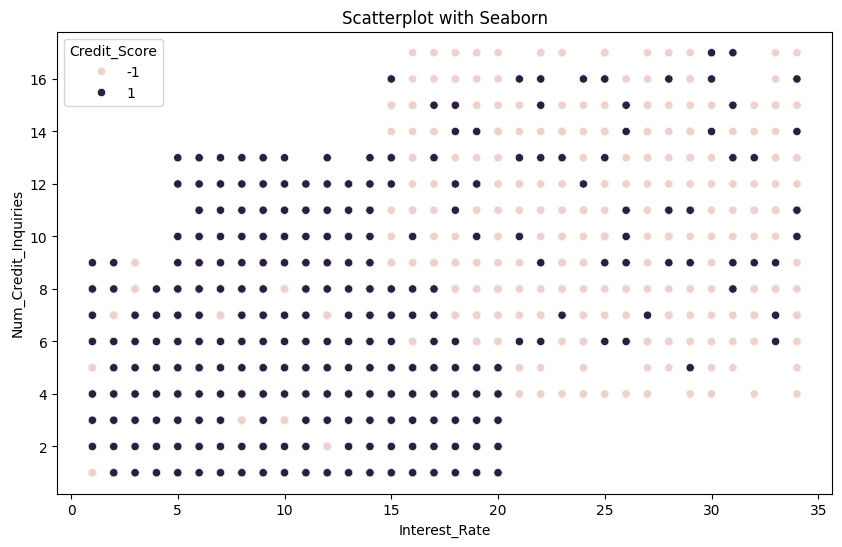

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Interest_Rate', y='Num_Credit_Inquiries', hue='Credit_Score', data=df_final)
plt.title('Scatterplot with Seaborn')
plt.xlabel('Interest_Rate')
plt.ylabel('Num_Credit_Inquiries')
plt.show()

The above graph shows 2 obvious clusters. The people who have a higher interest rate and more number of credit inquiries seem to have a poorer credit score, which makes sense. This gives confidence that these features will have high predictive power.

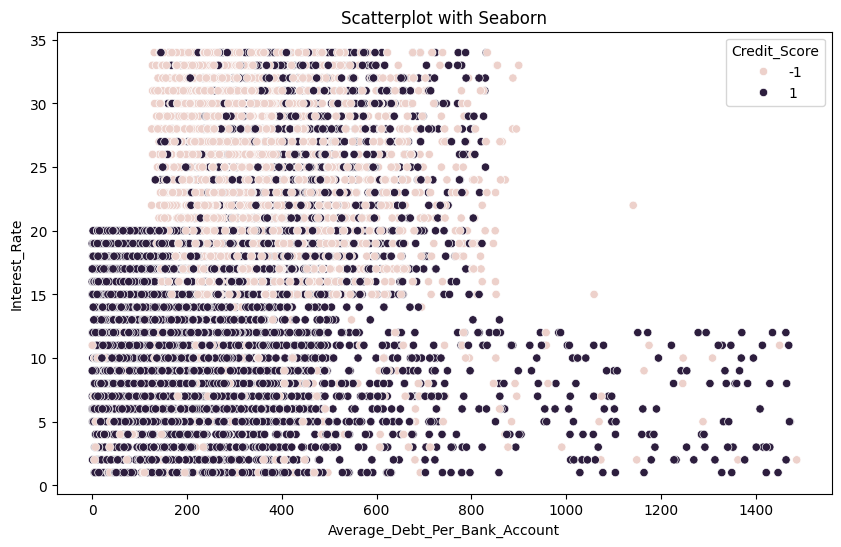

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Debt_Per_Bank_Account', y='Interest_Rate', hue='Credit_Score', data=df_final)
plt.title('Scatterplot with Seaborn')
plt.xlabel('Average_Debt_Per_Bank_Account')
plt.ylabel('Interest_Rate')
plt.show()

The above graph shows 2 clusters too. This one is a little more mixed. However, we can see that on average the higher the debt per bank account between 200 and 800 and high interest rate indicated more people with poorer credit scores.

We hope that this clustering is more apparent and distinct in higher dimensions.

Below, we look at the grid of all univariate/bivariate relationships. We focus mainly on the univariate graphs and solely plot them afterwards. The diagonal is the univariate graphs.

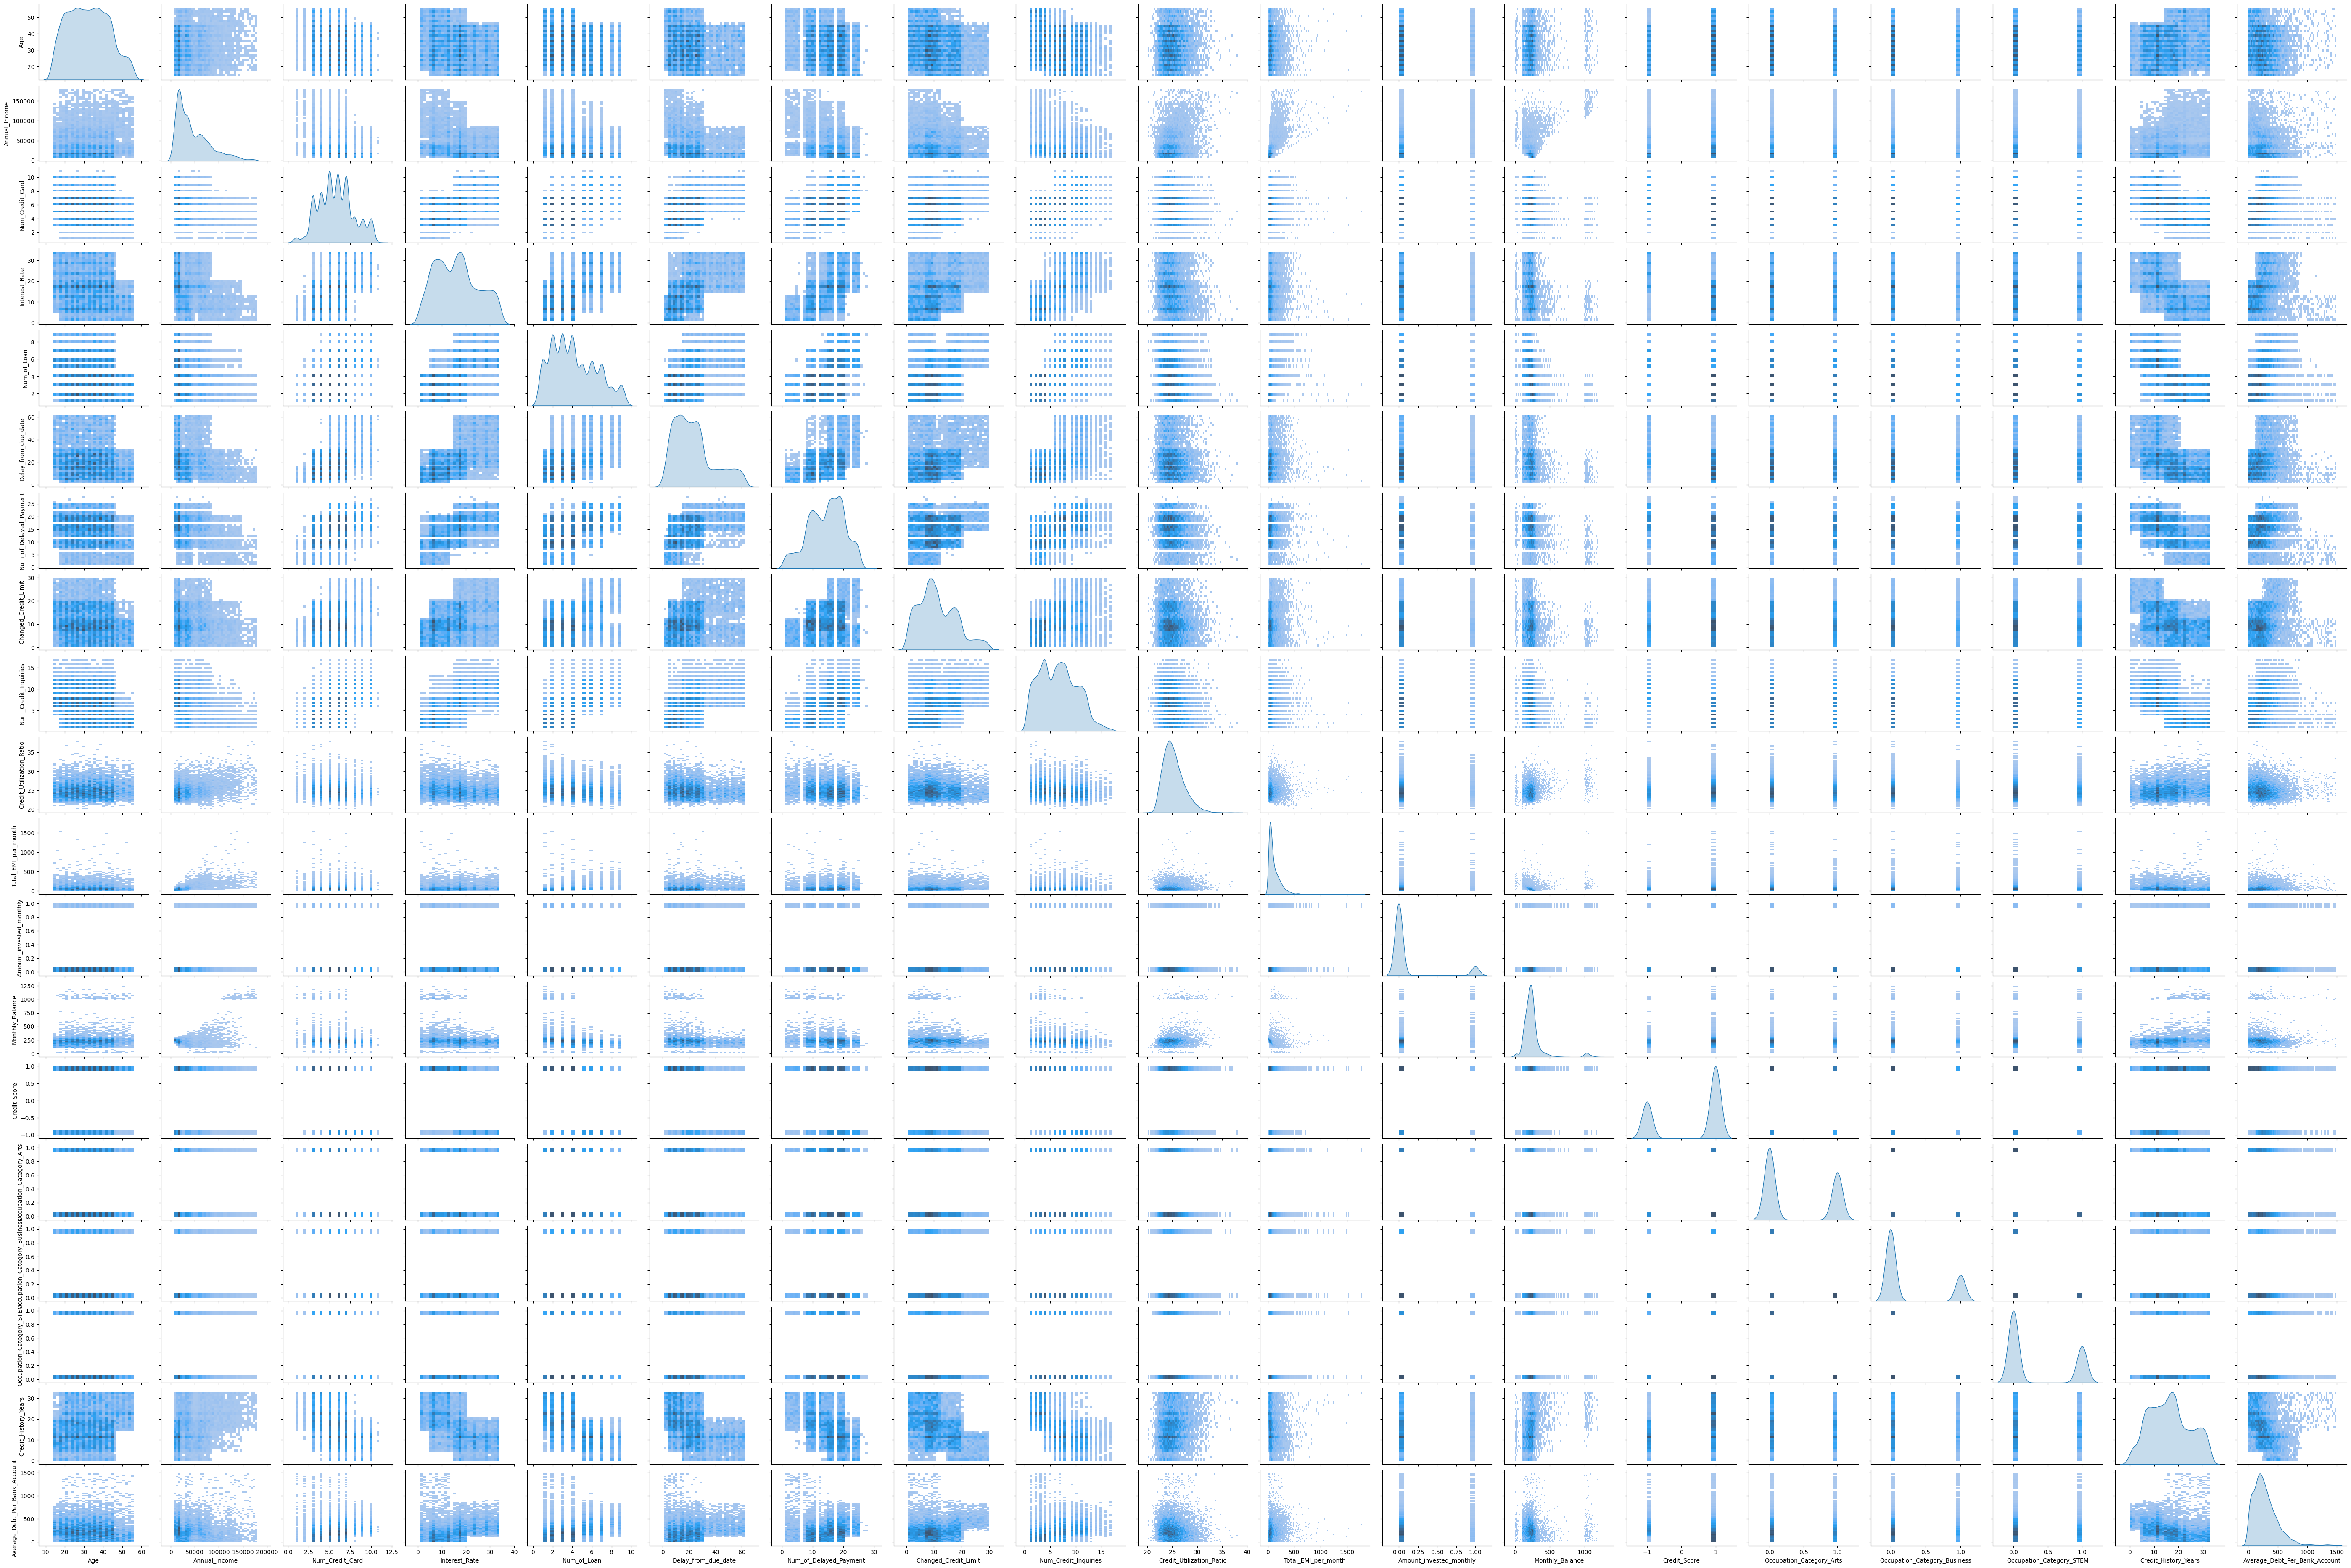

In [49]:
sns.pairplot(df_final, height=2, aspect=1.5, kind="hist", diag_kind="kde")

We now provide unvariate graphs of all the features individually. Due to their mostly peaked distributions, it seems reasonable to scale each feature using standard scaling to a normal distribution.

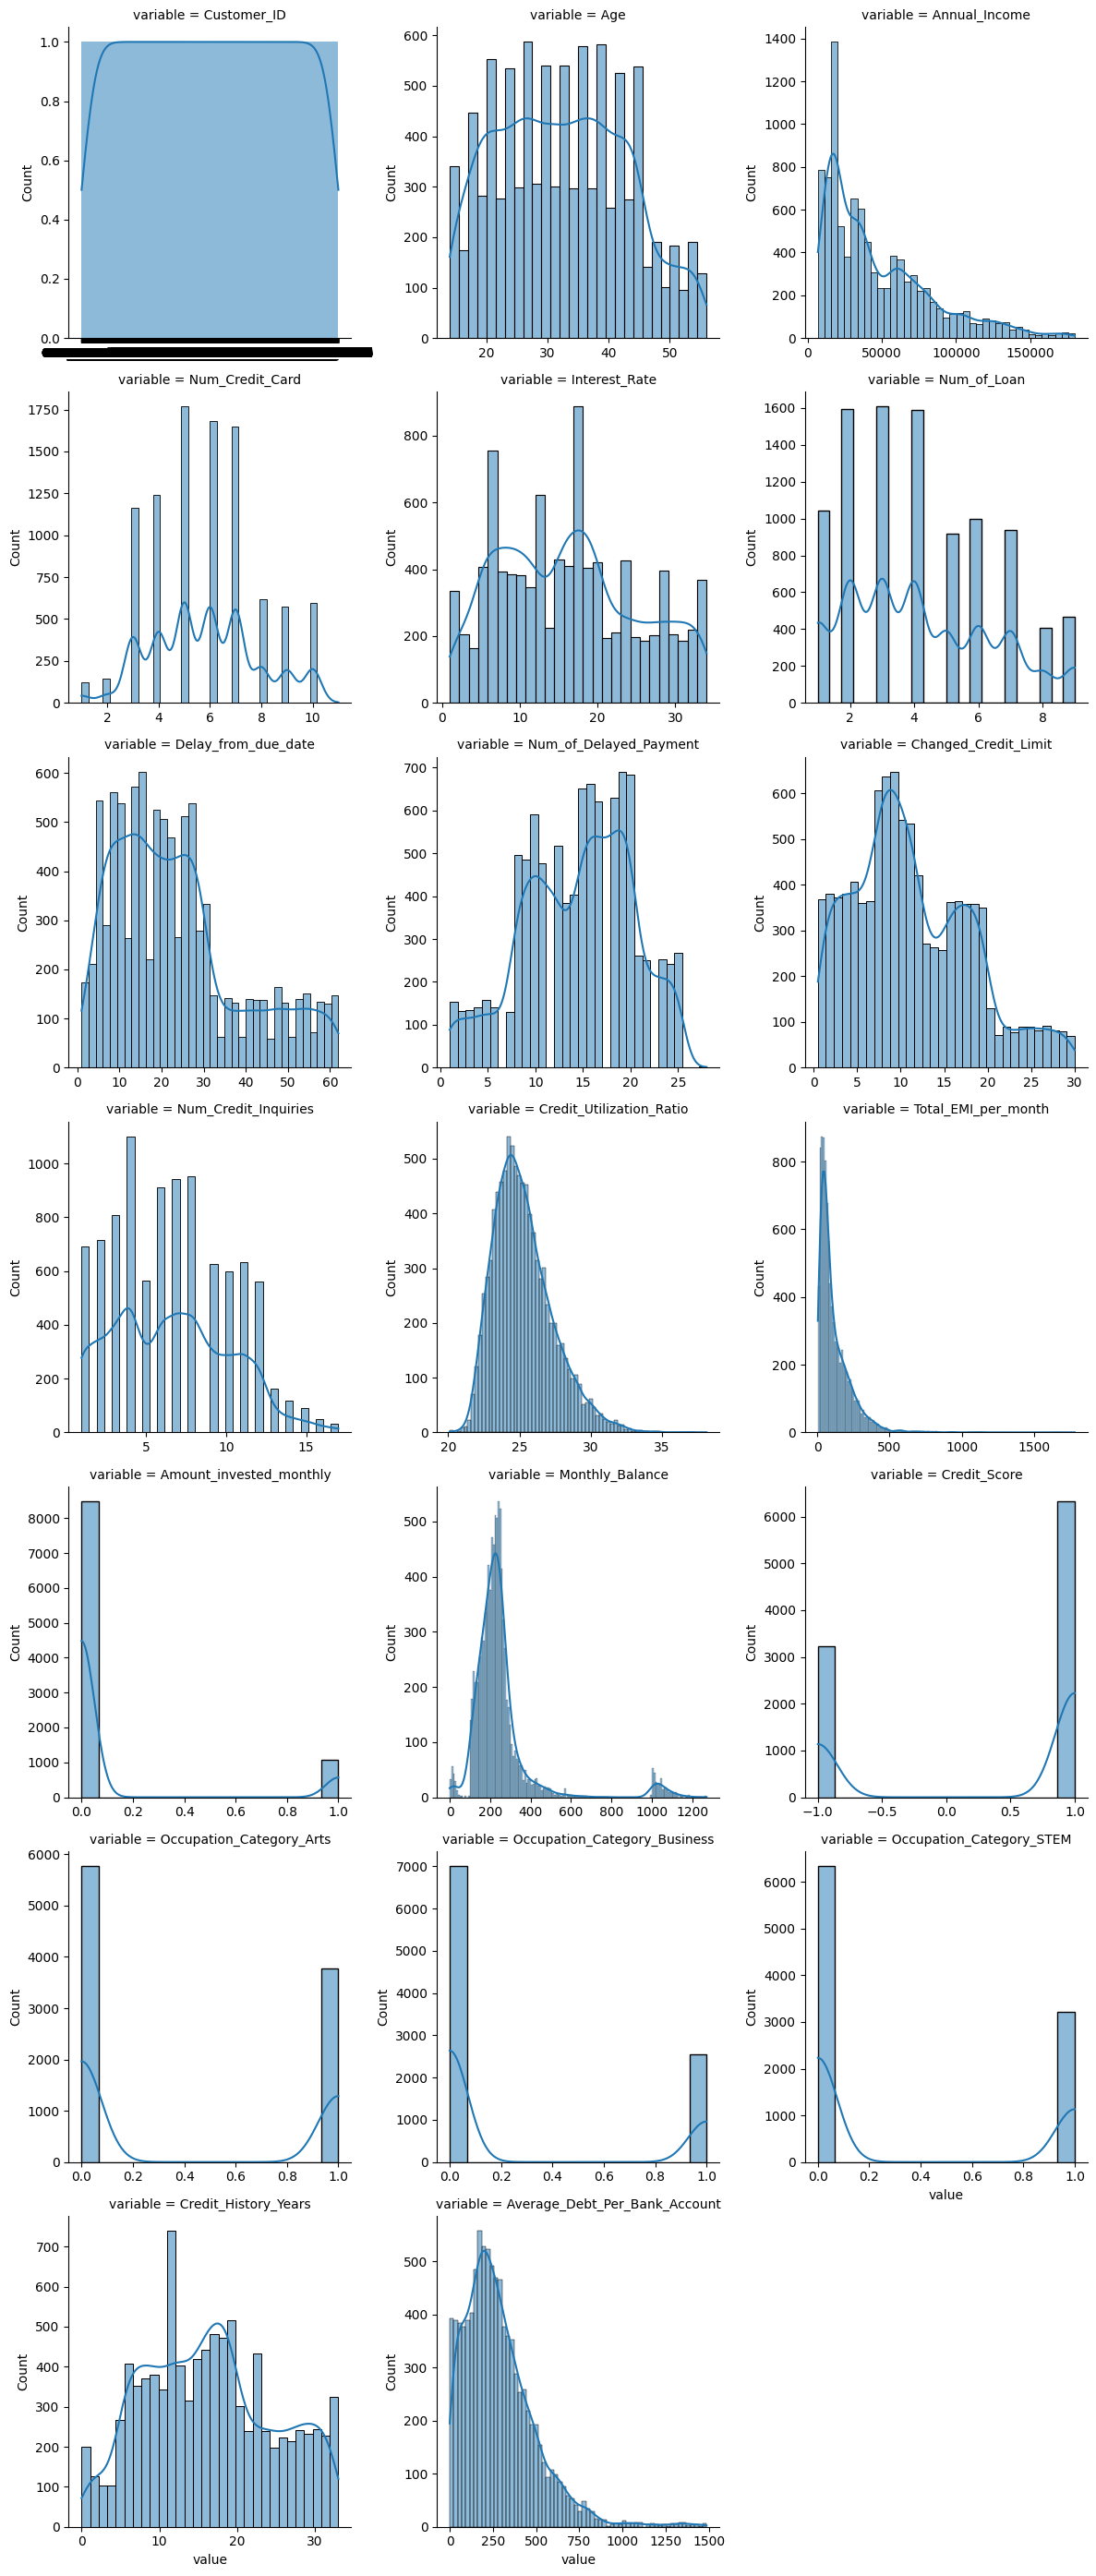

In [48]:
g = sns.FacetGrid(pd.melt(df_final), col="variable", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "value", kde=True)
plt.show()

We see that the Amounts_invested_monthly graph seems to have outliers. This wouldn't be good for any scaling method, and would provide no predictive power for the majority of the data. 

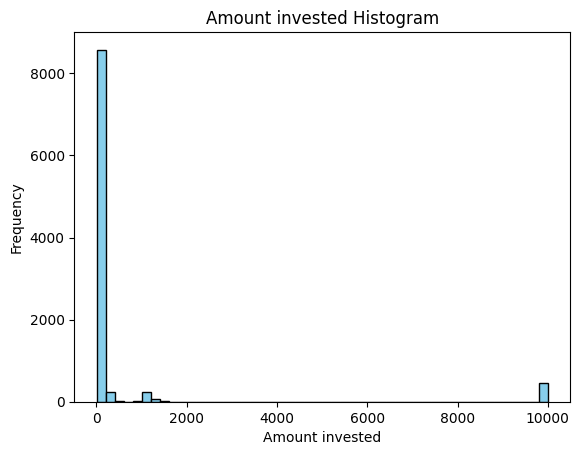

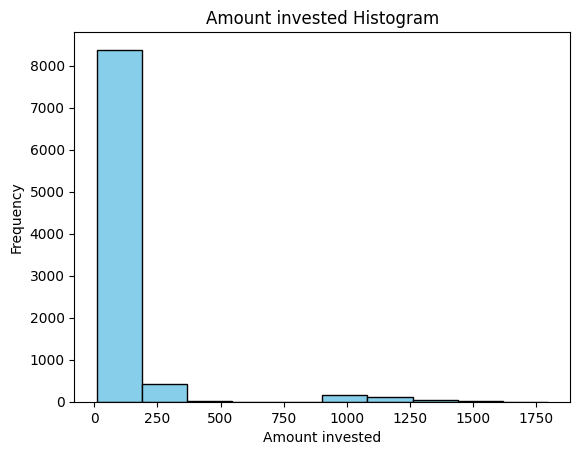

(10.009, 100.615]     912
(103.908, 107.513]    912
(111.804, 117.317]    912
(133.135, 147.465]    912
(178.099, 1797.63]    912
(100.615, 103.908]    911
(107.513, 111.804]    911
(117.317, 123.986]    911
(123.986, 133.135]    911
(147.465, 178.099]    911
Name: Amount_invested_monthly, dtype: int64


In [27]:
plt.hist(df_final['Amount_invested_monthly'], bins=50, color='skyblue', edgecolor='black')

plt.xlabel('Amount invested')
plt.ylabel('Frequency')
plt.title('Amount invested Histogram')
plt.show()

plt.hist(df_final[df_final['Amount_invested_monthly'] < 4000]['Amount_invested_monthly'], bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Amount invested')
plt.ylabel('Frequency')
plt.title('Amount invested Histogram')
plt.show()


bins = pd.qcut(df_final[df_final['Amount_invested_monthly'] < 4000]['Amount_invested_monthly'], q=10)  # You can adjust the number of quantiles (q) as needed

# Use value_counts to count occurrences within each bin
bin_counts = bins.value_counts(sort=True)
print(bin_counts)


To handle this, we decided to engineer the Amounts_invested into a binary feature, with a 1 above a threshold and a 0 otherwise. This threshold was chosen to be around the 80/90th percentile.

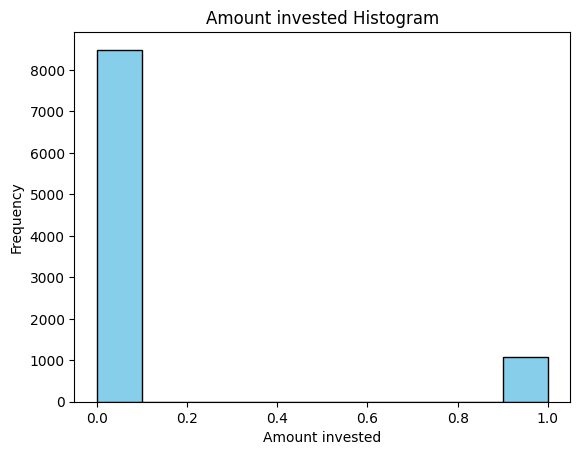

In [29]:
threshold = 200
df_final['Amount_invested_monthly'] = np.where(df_final['Amount_invested_monthly'] >= threshold, 1, 0)

plt.hist(df_final['Amount_invested_monthly'], bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Amount invested')
plt.ylabel('Frequency')
plt.title('Amount invested Histogram')
plt.show()

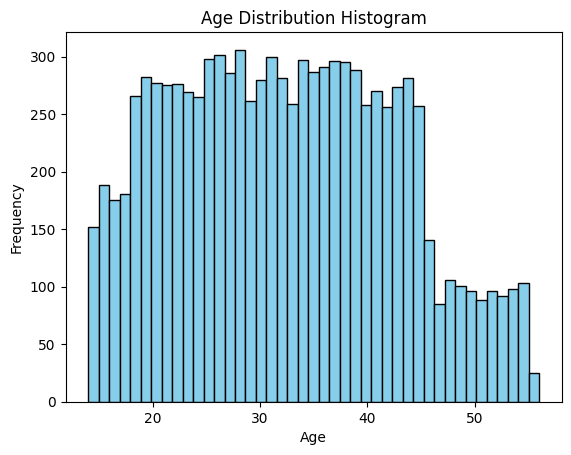

In [30]:
plt.hist(df_final['Age'], bins=43, color='skyblue', edgecolor='black')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution Histogram')

plt.show()

The age histogram looked abnormal, so we examine it further. The data now seems normal, and the spikes in the original graph came from the bins not including many integer values.

Since the ages seem to be uniformly distributed till age 45, we might be able to more accurately predict the credit score (good/bad) for someone within this age range (18 - 45).

### Data Setup

In [31]:
features_columns = ['Age', 'Annual_Income', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Occupation_Category_Arts',
       'Occupation_Category_Business', 'Occupation_Category_STEM',
       'Credit_History_Years', 'Average_Debt_Per_Bank_Account']

class_labels = df_final['Credit_Score']
features = df_final[features_columns]

## Modelling

### Decision Trees / Random Forests

We are going to work tuning a Decision Tree Model. We first ran a regular decision tree using SMOTE to balance our dataset. After this, we decided to run a CV and a nested CV by using GridSearch for the nested.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, class_labels, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train_resampled, y_train_resampled)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7599372384937239


In [33]:
# Cross Val


hyperparams = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15, 20]
}

model = DecisionTreeClassifier(criterion='entropy')

grid_search = GridSearchCV(model, hyperparams, cv=5, scoring='accuracy')

grid_search.fit(features, class_labels)

print("best_params: ", grid_search.best_params_)
print("best_acc: {:.2f}".format(grid_search.best_score_))

best_params:  {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 20}
best_acc: 0.83


In [34]:
# Nested Cross-Val
model = DecisionTreeClassifier(criterion='entropy')

hyperparams = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15, 20]
}

grid_search = GridSearchCV(model, hyperparams, cv=5, scoring='accuracy')

cv_scores = cross_val_score(grid_search, features, class_labels, cv=5)

print("acc for outer folds:", cv_scores)

print("avg_acc: {:.2f}".format(cv_scores.mean()))

acc for outer folds: [0.82060669 0.84675732 0.82740586 0.82949791 0.83882784]
avg_acc: 0.83


We will run Random Forests on our Dataset to get better accuracy and reduces overfitting by averaging multiple decision trees and is less sensitive to noise and outliers in the data. We can do a GridSearchCV here too (with hyperparam tuning), but since that is taking too long to run, we choose to use the hyperparams from the DecisionTreeClassifier 2 cells above.

In [35]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=15, min_samples_leaf=5)
smote = SMOTE(sampling_strategy='auto', random_state=42)
stratkf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(accuracy_score)

accuracy_scores = []
for train_index, test_index in stratkf_outer.split(features, class_labels):
    X_train_outer, X_test_outer = features.iloc[train_index], features.iloc[test_index]
    y_train_outer, y_test_outer = class_labels.iloc[train_index], class_labels.iloc[test_index]
    X_resampled, y_resampled = smote.fit_resample(X_train_outer, y_train_outer)
    cv_results = cross_val_score(rfc_model, X_resampled, y_resampled, cv=3, scoring=scoring)
    accuracy_scores.append(cv_results.mean())

print("acc for outer folds:", accuracy_scores)

print("avg_acc: {:.2f}".format(np.mean(accuracy_scores)))

acc for outer folds: [0.8306674565560822, 0.8276417204759827, 0.8288267885019046, 0.8235948821621591, 0.8281351089822847]
avg_acc: 0.83


We have a model we are confident with as one of our base classifiers when we ensemble multiple models. We went through the process of hyperparamater tuning and making the random forest.

### Support Vector Machine (SVM)

Here we are running a nested cross validation on the SVM model where we are picking best hyperparameters (cost and the kernel type) and we are also making sure to standardize our data before doing anything. This will also become one of the base classifer in the ensembling at the end.

In [36]:
scaler = StandardScaler()
svc = SVC()

pipeline = Pipeline([
    ('scaler', scaler),
    ('svc', svc),
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
}

svm_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
svm_grid_search.fit(features, class_labels)
svm_best_param = svm_grid_search.best_params_

print("Best Param: ", svm_best_param)

Best Param:  {'svc__C': 1, 'svc__kernel': 'rbf'}


In [37]:
subset_size = 5000
features_subset = features.sample(n=subset_size, random_state=42)
class_labels_subset = class_labels.sample(n=subset_size, random_state=42)

scaler = StandardScaler()
svc = SVC()

pipeline = Pipeline([
    ('scaler', scaler),
    ('svc', svc),
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
}

svm_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
svm_predictions = cross_val_predict(svm_grid_search, features_subset, class_labels_subset, cv=5)

svm_accuracy = accuracy_score(class_labels_subset, svm_predictions)
print("SVM Acc: {:.2f}".format(svm_accuracy))
print("Classification report:")
print(classification_report(class_labels_subset, svm_predictions))

SVM Acc: 0.83
Classification report:
              precision    recall  f1-score   support

          -1       0.78      0.68      0.73      1651
           1       0.85      0.91      0.88      3349

    accuracy                           0.83      5000
   macro avg       0.82      0.79      0.80      5000
weighted avg       0.83      0.83      0.83      5000



# KNN

For KNN, we are doing instance based learning where we try to predict a record based on its k-nearest neighbors. We decide what k to by running nested cross validation.

In [38]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

pipeline = Pipeline([
    ('scaler', scaler),
    ('knn', knn)
])

accuracies = cross_val_score(pipeline, features, class_labels, cv=5)

print("avg_acc: {:.2f}".format(accuracies.mean()))

avg_acc: 0.81


In [39]:
param_grid = {
    'knn__n_neighbors': list(range(1, 25))
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5)

grid_search.fit(features, class_labels)

print("best k neighbors:", grid_search.best_params_['knn__n_neighbors'])
print("best acc:", grid_search.best_score_)

best k neighbors: 19
best acc: 0.8285396810800277


In [40]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

cv_scores = cross_val_score(grid_search, features, class_labels, cv=5)

print("acc for outer folds:", cv_scores)
print("avg_acc: {:.2f}".format(cv_scores.mean()))

acc for outer folds: [0.82792887 0.82845188 0.82426778 0.82060669 0.83725798]
avg_acc: 0.83


In [41]:
preds = cross_val_predict(grid_search, features, class_labels, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(class_labels, preds))
print("\nClassification Report:")
print(classification_report(class_labels, preds, target_names=['0', '1']))

Confusion Matrix:
[[2215 1013]
 [ 634 5697]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      3228
           1       0.85      0.90      0.87      6331

    accuracy                           0.83      9559
   macro avg       0.81      0.79      0.80      9559
weighted avg       0.82      0.83      0.82      9559



### Naive Bayes

We used NB as another classifier to predict YES/NO for approving a loan (credit score good/standard or poor)

In [42]:
model = make_pipeline(GaussianNB())
features_resampled, class_labels_resampled = SMOTE(random_state=42).fit_resample(features, class_labels)
cv_scores = cross_val_score(model, features_resampled, class_labels_resampled, cv=10)

print("Acc for folds:", cv_scores)
print("Avg_acc: {:.2f}".format(cv_scores.mean()))

Acc for folds: [0.80110497 0.81136543 0.80252765 0.78593997 0.79778831 0.82701422
 0.81437599 0.80884676 0.8135861  0.81595577]
Avg_acc: 0.81


In [43]:
preds = cross_val_predict(model, features, class_labels, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(class_labels, preds))
print("\nClassification Report:")
print(classification_report(class_labels, preds, target_names=['0', '1']))

Confusion Matrix:
[[2694  534]
 [1365 4966]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.74      3228
           1       0.90      0.78      0.84      6331

    accuracy                           0.80      9559
   macro avg       0.78      0.81      0.79      9559
weighted avg       0.82      0.80      0.81      9559



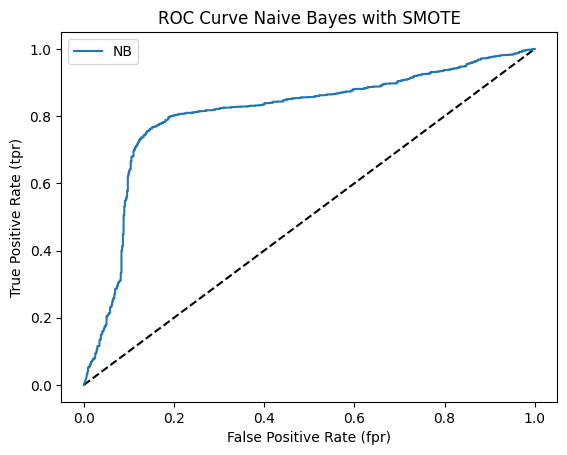

AUC: 0.8078684663242468


In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(features, class_labels, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = Pipeline([
    ('nb', GaussianNB())
])

model.fit(X_train_resampled, y_train_resampled)
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], 'k--')  
plt.plot(fpr, tpr, label='NB')
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title('ROC Curve Naive Bayes with SMOTE')
plt.legend()
plt.show()

print("AUC:", roc_auc_score(y_test, probs))

When looking at the ROC Curve, we can see that the AUC is 0.80 and from the class slides and AUC between 0.80 and 0.90 is classified as good - so we have a good tradeoff between sensitivity and specificity.

### Neural Network

Similar to previous methods, we use a grid search to find the best parameters for a neural network. The input layer has 18 nodes (because 18 features), and the output layer has 1 node (classification).

We use 1 inner layer (since more than that seems to be unecessary), and we test for 10, 20, and 30 nodes for the inner layer. We chose this range of numbers because it is around the number of nodes in the input layer.

We also test for 3 different activation functions.

In [45]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

#put your code in a function and add the following decorator to it
@ignore_warnings(category=ConvergenceWarning)
def run_nn():
    scaler = StandardScaler()
    neural_net = MLPClassifier()
    pipeline = Pipeline([
        ('scaler', scaler),
        ('mlp', neural_net)
    ])

    param_grid = {
        'mlp__hidden_layer_sizes': [(10,), (20,), (30,)],
        'mlp__activation': ['logistic', 'tanh', 'relu']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(features, class_labels)
    nested_scores = cross_val_score(grid_search, features, class_labels, cv=5)

    print("Average Accuracy:", nested_scores.mean() * 100)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    print("Best Accuracy:", grid_search.best_score_ * 100)


run_nn()

Average Accuracy: 83.71181816788511
Best Parameters: {'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': (30,)}
Best Accuracy: 83.99425589353861


# Voting Ensembling

We decided to take a voting of all the base classifiers discussed above, with the respective best parameters.

In [46]:
from sklearn.ensemble import VotingClassifier
import warnings
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.simplefilter('ignore', ConvergenceWarning)

smote = SMOTE(sampling_strategy='auto', random_state=42)

decision_tree_pipe = ImbPipeline([('smote', smote), ('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=100, max_depth=5, max_features=15, min_samples_leaf=5))])
svm_pipe = ImbPipeline([('smote', smote), ('scaler', StandardScaler()), ('model', SVC(C=1, kernel='rbf'))])
knn_pipe = ImbPipeline([('smote', smote), ('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=11))])
nb_pipe = ImbPipeline([('smote', smote), ('scaler', StandardScaler()), ('model', GaussianNB())])
nn_pipe = ImbPipeline([('smote', smote), ('scaler', StandardScaler()), ('model', MLPClassifier(hidden_layer_sizes=(20,), activation='logistic'))])

voting_classifier = VotingClassifier(
    estimators=[
        ('dt', decision_tree_pipe),
        ('svm', svm_pipe),
        ('knn', knn_pipe),
        ('nb', nb_pipe),
        ('nn', nn_pipe)
    ],
    voting='hard'
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(voting_classifier, features, class_labels, cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Average Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.82688285 0.80910042 0.83838912 0.83943515 0.81580324]
Average Accuracy: 0.8259221551510851


This shows that ensembling doesn't significantly improve on the individual methods we tested. Regardless of whether or not SMOTE was used or which subset of models were ensembled together, all experiments showed no improvement using ensembling compared to individual models.

This could be because ensembling is most effective with simple poor-fitted models used together. Many of our models are already quite complex and fit the data decently well. Ensembling complex models togehter, thus, might not provide as much improvement, which is what we see.  

# Conclusion

Our data processing included validating the data, removing outliers and unnecessary features, creating new features, and consolidating customers into a single datapoint. 
We then applied 5 models: Decision Trees/Random Forest, Support Vector Machines, K-Nearest Neighbors, Naive Bayes, and Neural Networks. We then ensembled these methods together. We used nested cross validation throughout, with a grid search to test for the best hyperparameters.

Our 5 models did remarkably similar, all with around an 80% accuracy rate. The ensemble model also did not improve the accuracy. As noted, we believe this is due to the underlying models already being significantly complex. The model with the highest accuracy was the nueral network, with 84% accuracy.